In [1]:
from ThesisPackage.Environments.multi_pong_sender_receiver_ball_onehot import PongEnvSenderReceiverBallOneHot
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy

In [2]:
def make_env(max_episode_steps = 512, sequence_length = 1, vocab_size = 3):
    env = PongEnvSenderReceiverBallOneHot(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps)
    # env = ParallelFrameStack(env, 4)
    return env

In [3]:
def load(path="models/checkpoints"):
    env = make_env()
    models = {}
    for model in os.listdir(path):
        if "pong" in model:
            state_dict = torch.load(os.path.join(path, model))
            timestamp = model.split("_")[-1]
            timestamp = int(timestamp.split(".")[0])
            agent = PPO_Multi_Agent_Centralized(env, device="cpu")
            agent.agent.load_state_dict(state_dict)
            models[timestamp] = agent
    return models

In [4]:
def plot_language_saliencies(full_saliences, path=None):
    plt.figure(figsize=(20, 5))  # Adjust figure size to make it more readable

    plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

    plt.plot(plot_saliences[:, -1], label='Channel 2')
    plt.plot(plot_saliences[:, -2], label="Channel 1")
    # plt.plot(saliencies)
    plt.title('Saliency of language channel')
    plt.xlabel('Timestep')
    plt.ylabel('Saliency Sum')
    plt.legend()
    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [5]:
import copy

def record_data(env, data):
    data["ball_1"].append(copy.deepcopy(env.balls["ball_1"]["position"]))
    data["ball_2"].append(copy.deepcopy(env.balls["ball_2"]["position"]))
    data["direction_1"].append(copy.deepcopy(env.balls["ball_1"]["direction"]))
    data["direction_2"].append(copy.deepcopy(env.balls["ball_2"]["direction"]))
    data["paddle_1"].append(copy.deepcopy(env.paddles["paddle_1"]))
    data["paddle_2"].append(copy.deepcopy(env.paddles["paddle_2"]))
    data["distances"].append(copy.deepcopy(abs(env.paddles["paddle_1"] - env.paddles["paddle_2"])))
    try:
        data["utterance paddle_1"].append(copy.deepcopy(env.utterances["paddle_1"].tolist()))
        data["utterance paddle_2"].append(copy.deepcopy(env.utterances["paddle_2"].tolist()))
    except:
        data["utterance paddle_1"].append(copy.deepcopy(env.utterances["paddle_1"]))
        data["utterance paddle_2"].append(copy.deepcopy(env.utterances["paddle_2"]))
    return data

In [6]:
def perturbation(inputs, model, vocab_size, sequence_length):
    
    # Extract environment inputs
    environment_inputs = inputs[:, :-1 * vocab_size * sequence_length]

    # Extract original logits
    inputs = torch.tensor(inputs, dtype=torch.float32)
    original_logits = model(inputs)
    original_logits = F.softmax(original_logits, dim=1).detach().numpy()
    original_logits = F.log_softmax(torch.tensor(original_logits), dim=1).detach()

    perturbation_logits = []
    for token in range(vocab_size):
        # One-hot encoded sequence of tokens
        utterances = np.array([token for _ in range(sequence_length)])
        utterances = np.eye(vocab_size)[utterances].flatten()
        utterances = np.expand_dims(utterances, axis=0)
        utterances = np.repeat(utterances, inputs.shape[0], axis=0)

        # Concatenate environment inputs with utterances
        perturbation_inputs = np.concatenate((environment_inputs, utterances), axis=1)
        perturbation_inputs = torch.tensor(perturbation_inputs, dtype=torch.float32)

        # Get logits for perturbed inputs
        current_logits = model(perturbation_inputs).detach().numpy()
        current_logits = F.softmax(torch.tensor(current_logits), dim=1).detach().numpy()

        perturbation_logits.append(current_logits)

    divergences = []
    for input_array in perturbation_logits:
        kl_divergences = []
        for i in range(len(input_array)):
            q = F.softmax(torch.tensor(input_array[i]), dim=0)
            kl_div = F.kl_div(original_logits, q, reduction='batchmean').item()
            kl_divergences.append(kl_div)

        divergences.append(kl_divergences)
    max_divergences = np.max(divergences, axis=0)
    return max_divergences

In [7]:
def test_perturbation(env, agent, epochs=1, tracking_agent="paddle_1", threshold=0.002, use_perturbation=False):
    language_importances = []
    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    data = {"ball_1": [], "ball_2": [], "direction_1":[], "direction_2":[], "paddle_1": [], "paddle_2": [], "distances":[], "utterance paddle_1":[], "utterance paddle_2":[]}

    for i in range(epochs):
        timestep = 0
        while True:
            timestep += 1
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            data = record_data(env, data)
            
            # integrated_grads = smoothgrad(obs_track, agent.agent.actor, 0, sigma=1.0, steps=30)
            language_perturbation = perturbation(obs, agent.agent.actor, env.vocab_size, env.sequence_length)
            language_importances.append(language_perturbation)

            # If any of language_importances is higher thnan 0.002
            if any([importance >= threshold for importance in language_perturbation]) and use_perturbation:
                language_observations = obs[:, -1 * env.vocab_size * env.sequence_length:]
                random_language = np.random.randint(0, env.vocab_size, (language_observations.shape[0], env.sequence_length))
                random_language = np.eye(env.vocab_size)[random_language]
                random_language = np.squeeze(random_language, axis=1)
                obs[:, -1 * env.vocab_size * env.sequence_length:] = random_language

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
    return np.array(language_importances), data, average_length

In [8]:
num_steps = 10000
agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/saliencies_live/Multi_Pong/Sequence_Length_1")
agent_indizes = list(agents.keys())
agent_indizes.sort()
env = make_env(max_episode_steps=2048)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [9]:
results = {}

In [10]:
def share_above_threshold(arr, threshold=0.15):
    # Check if each element is greater than the threshold
    condition = arr > threshold
    # Count rows where at least one element satisfies the condition
    count = np.any(condition, axis=1).sum()
    # Calculate the share
    share = count / arr.shape[0]
    return share

In [11]:
importances, data, lengths = test_perturbation(env, agents[agent_indizes[-1]], epochs=300, threshold=0.002, use_perturbation=False)
noise_share = share_above_threshold(importances, threshold=0.002)
results["no noise"] = {"lengths": np.mean(lengths), "share_above_threshold": noise_share}

In [12]:
importances, data, lengths = test_perturbation(env, agents[agent_indizes[-1]], epochs=300, threshold=0.002, use_perturbation=True)
noise_share = share_above_threshold(importances, threshold=0.002)
results["perturbation"] = {"lengths": np.mean(lengths), "share_above_threshold": noise_share}

In [13]:
importances, data, lengths = test_perturbation(env, agents[agent_indizes[-1]], epochs=300, threshold=0.0, use_perturbation=True)
noise_share = share_above_threshold(importances, threshold=0.00)
results["perturbation_no_threshold"] = {"lengths": np.mean(lengths), "share_above_threshold": noise_share}

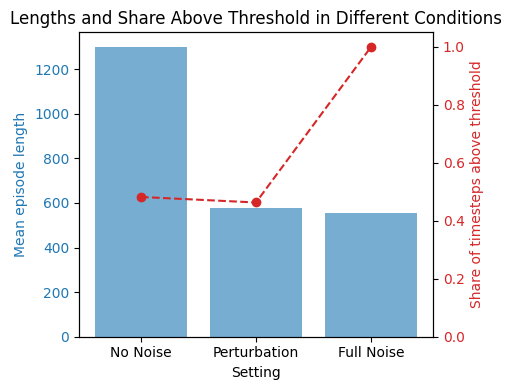

In [14]:
import matplotlib.pyplot as plt

# Data
conditions = ["No Noise", "Perturbation", "Full Noise"]
lengths = [results[condition]["lengths"] for condition in results.keys()]
threshold_share = [results[condition]["share_above_threshold"] for condition in results.keys()]

# Plotting
fig, ax1 = plt.subplots(figsize=(5, 4))

# Lengths
ax1.set_xlabel('Setting')
ax1.set_ylabel('Mean episode length', color='tab:blue')
ax1.bar(conditions, lengths, color='tab:blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Share Above Threshold
ax2 = ax1.twinx()
ax2.set_ylabel('Share of timesteps above threshold', color='tab:red')
ax2.plot(conditions, threshold_share, color='tab:red', marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 1.05)

plt.title('Lengths and Share Above Threshold in Different Conditions')
plt.tight_layout()
plt.show()


In [15]:
env = make_env()
importances, data, lengths = test_perturbation(env, agents[agent_indizes[-1]])
print(importances.shape)

(512, 2)


In [16]:
print(data["utterance paddle_1"])

[[0, 0, 0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1

In [17]:
pertubation_files = os.listdir("perturbation")
pertubation_files = [int(file) for file in pertubation_files if file != ".DS_Store"]

try:
    max_index = max(pertubation_files)
    new_index = max_index + 1
except:
    new_index = 0

os.mkdir(f"perturbation/{new_index}")

# Store data as a json
import json
with open(f"perturbation/{new_index}/data.json", "w") as file:
    json.dump(data, file)

# Store numpy array language_importances
np.save(f"perturbation/{new_index}/importances.npy", importances)

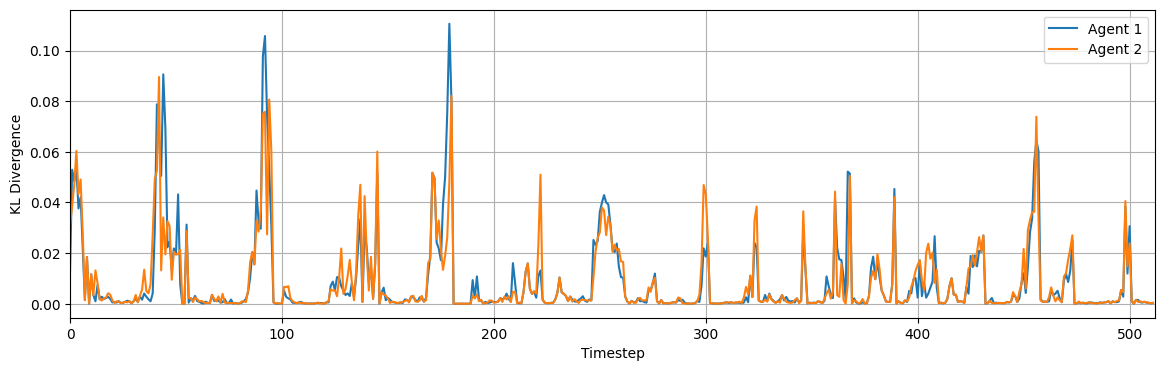

In [18]:
import matplotlib.pyplot as plt

# Plot the two lines
plt.figure(figsize=(14, 4))
plt.plot(importances[:, 0], label='Agent 1')
plt.plot(importances[:, 1], label='Agent 2')
plt.xlabel('Timestep')
plt.ylabel('KL Divergence')
ax = plt.gca()
ax.set_xlim([0, len(data["distances"])])
plt.legend()
plt.grid(True)
plt.savefig(f"perturbation/{new_index}/language_importances.pdf")

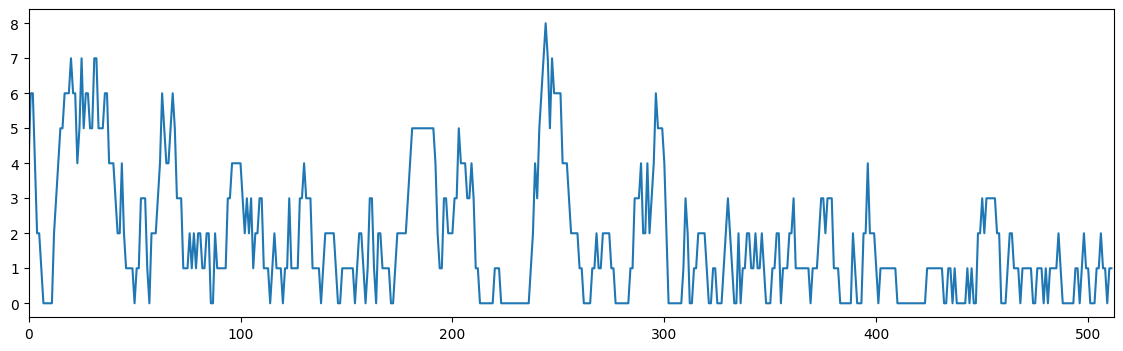

In [19]:
plt.figure(figsize=(14, 4))
ax = plt.gca()
ax.set_xlim([0, len(data["distances"])])
plt.plot(data["distances"])
plt.savefig(f"perturbation/{new_index}/distance.pdf")

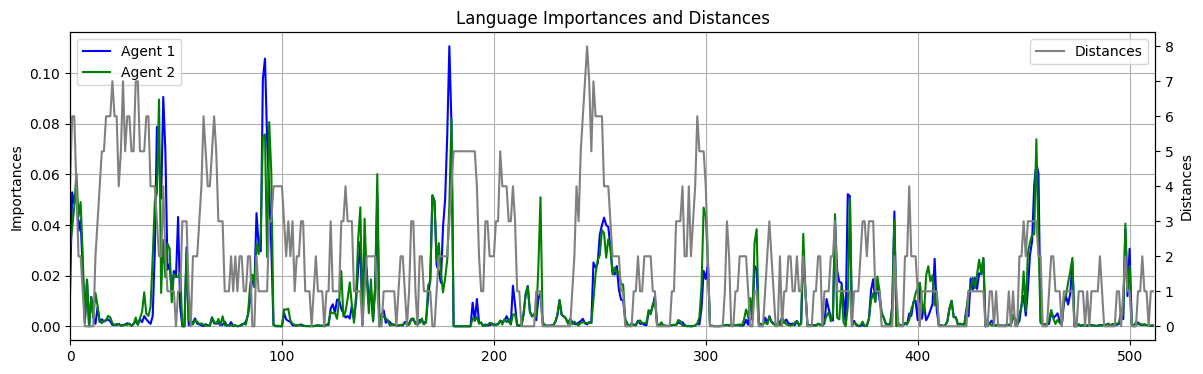

In [20]:
import matplotlib.pyplot as plt

# Assuming importances and data are defined elsewhere in the script
# importances should be a 2D array-like structure with two columns
# data["distances"] should be an array-like structure

fig, ax1 = plt.subplots(figsize=(14, 4))

# Plot the importances on the first y-axis
ax1.plot(importances[:, 0], label='Agent 1', color='blue')
ax1.plot(importances[:, 1], label='Agent 2', color='green')
ax1.set_title('Language Importances and Distances')
ax1.set_xlim([0, len(data["distances"])])
ax1.set_ylabel('Importances')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for the distances
ax2 = ax1.twinx()
ax2.plot(data["distances"], label='Distances', color='grey')
ax2.set_ylabel('Distances')
ax2.legend(loc='upper right')

plt.savefig(f"perturbation/{new_index}/language_importances_and_distances.pdf")

In [21]:
# Calculate the average of both values in each row
average_values = importances.mean(axis=1)

# Get the indices of the top 10 highest average values
top_10_indices = np.argsort(average_values)[-10:][::-1]

In [22]:
import pygame

pygame.init()
window_size = 600  # Set the size of the window
cell_size = window_size // max(env.width, env.height)
screen = pygame.display.set_mode((env.width * cell_size, env.height * cell_size))
pygame.display.set_caption('Pong Environment')
clock = pygame.time.Clock()

def render_pygame(env, data, index, mode='pygame'):
    # Initialize PyGame if variable already exists

    # Set screen background and basic colors
    screen.fill((0, 0, 0))  # Black background
    paddle_color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Colors for paddles

    # Draw paddles
    paddle_width = cell_size
    paddle_height = cell_size * env.paddle_height

    paddles = {"paddle_1": data["paddle_1"][index], "paddle_2": data["paddle_2"][index]}
    balls = {"ball_1":
              {"position": data["ball_1"][index], "direction": data["direction_1"][index]},
             "ball_2":
              {"position": data["ball_2"][index], "direction": data["direction_2"][index]}
            }

    for i, paddle in enumerate(paddles.keys()):
        paddle_pos = paddles[paddle]

        pygame.draw.rect(screen, paddle_color[i], pygame.Rect((env.width * cell_size - cell_size, paddle_pos * cell_size), (paddle_width, paddle_height)))

    # Draw balls
    for ball in balls.keys():
        ball_pos = [cur_pos  * cell_size for cur_pos in balls[ball]["position"]]
        ball_direction = balls[ball]["direction"]
        pygame.draw.circle(screen, (255, 255, 255), ball_pos, 10)
        pygame.draw.line(screen, paddle_color[i], ball_pos, (ball_pos[0] + ball_direction[0] * 30, ball_pos[1] + ball_direction[1] * 30), 10)

    # Update the display
    pygame.display.flip()

    # Handle quitting from the window
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()

In [23]:
all_images_stored = False
for index in top_10_indices:
    if not all_images_stored:
        render_pygame(env, data, index)
        pygame.image.save(screen, f"perturbation/{new_index}/frame_{index}.png")
    render_pygame(env, data, index)
    time.sleep(1.0)
pygame.quit()

/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_97135/740580001.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_values)).colors  # Get a colormap with enough colors
/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_97135/740580001.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cax = axes[i, 1].imshow(combined_array, cmap=cmap)


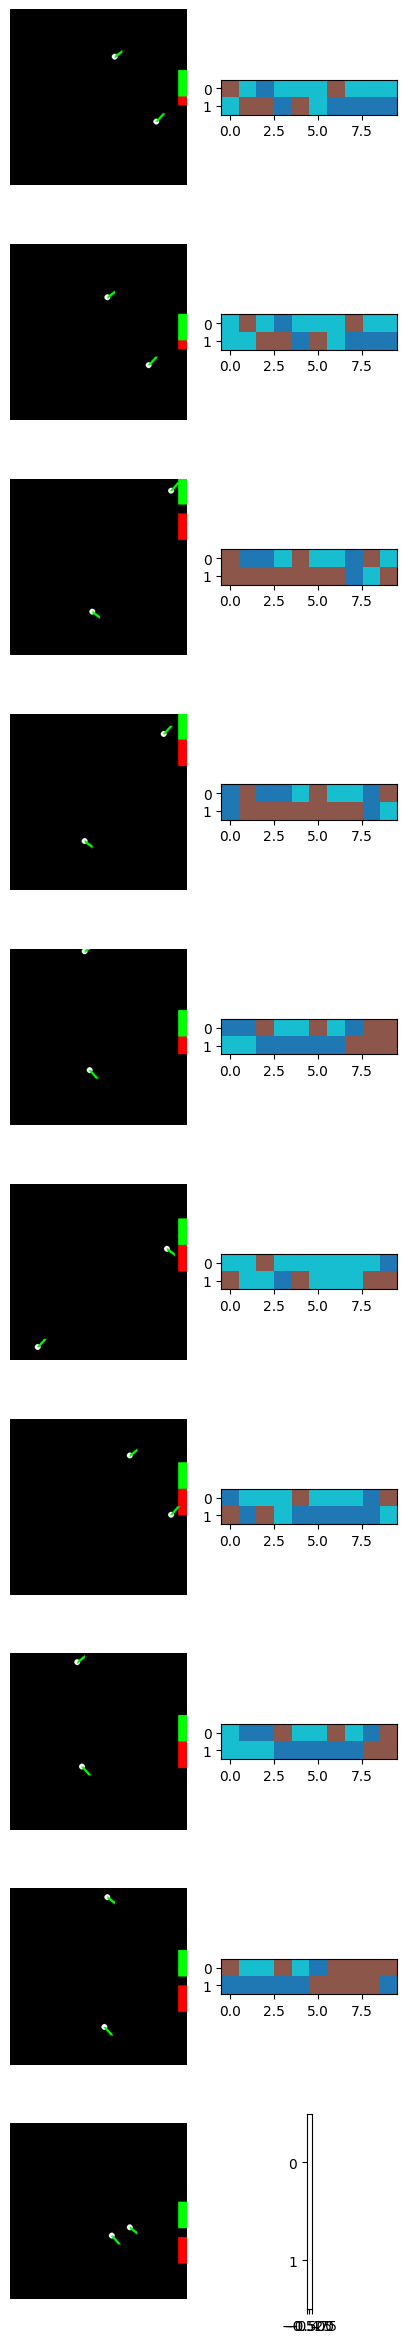

: 

In [24]:
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 10 * 3))

for i, index in enumerate(top_10_indices):
    # load and plot image
    img = plt.imread(f"perturbation/{new_index}/frame_{index}.png")
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    utterances_paddle_1 = data["utterance paddle_1"][index - 5: index + 5]
    utterances_paddle_2 = data["utterance paddle_2"][index - 5: index + 5]

    reshaped_utterance_paddle_1 = np.array(utterances_paddle_1).reshape(-1, env.vocab_size)
    reshaped_utterance_paddle_2 = np.array(utterances_paddle_2).reshape(-1, env.vocab_size)

    original_utterance_paddle_1 = np.argmax(reshaped_utterance_paddle_1, axis=1)
    original_utterance_paddle_2 = np.argmax(reshaped_utterance_paddle_2, axis=1)

    combined_array = np.array([original_utterance_paddle_1, original_utterance_paddle_2])

    unique_values = np.unique(combined_array)
    colors = plt.cm.get_cmap('tab10', len(unique_values)).colors  # Get a colormap with enough colors
    cmap = ListedColormap(colors)

    cax = axes[i, 1].imshow(combined_array, cmap=cmap)

    axes[i, 1].set_yticks([0, 1])